# Time Series Forecasting

Time series forecasting is one of the most challenging fields of machine learning. It's comparatively easier when there is some kind of trend or seasonality in the data. But when there is no such trend or seasonaity in the data, it becomes very difficult to forecast. In this notebook, we will compare some of the popular statistical machine learning algorithms/modules for time series forecasting.

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from sklearn.metrics import mean_squared_error

We will be using appliances enerygy prediction dataset for this excercise.

## Data

In [166]:
df = pd.read_csv('../input/appliances-energy-prediction/KAG_energydata_complete.csv')
df.head(n=3)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


There is one data point for every 10 mins.

In [167]:
print(df['date'][0])
type(df['date'][0])

2016-01-11 17:00:00


str

The datefield is a string. It needs to be converted to datetime or pandas timestamp format

In [168]:
df['date'] = pd.to_datetime(df['date'])

print(df['date'][0], list(df['date'])[-1])
type(df['date'][0])

2016-01-11 17:00:00 2016-05-27 18:00:00


pandas._libs.tslibs.timestamps.Timestamp

Dataset is big. It has almost 5 months of data. We will consider only one month of data. 

In [169]:
data = df[(df['date'] > '2016-02-01 00:00:00') & (df['date'] < '2016-02-28 23:59:59')]
data = data.reset_index(drop=True)

In [170]:
# Number of rows in filtered dataframe
len(data)

4031

In [171]:
# Lets remove all columns other than timestamp and column of interest
data = data[['date','RH_1']]

# Rename date to timestamp and RH_1 to value
data = data.rename(columns={'date': 'timestamp', 'RH_1': 'value'})

In [172]:
data.head(n=5)

,timestamp,value
0,2016-02-01 00:10:00,46.433333
1,2016-02-01 00:20:00,46.522500
2,2016-02-01 00:30:00,46.590000
3,2016-02-01 00:40:00,46.730000
4,2016-02-01 00:50:00,46.790000


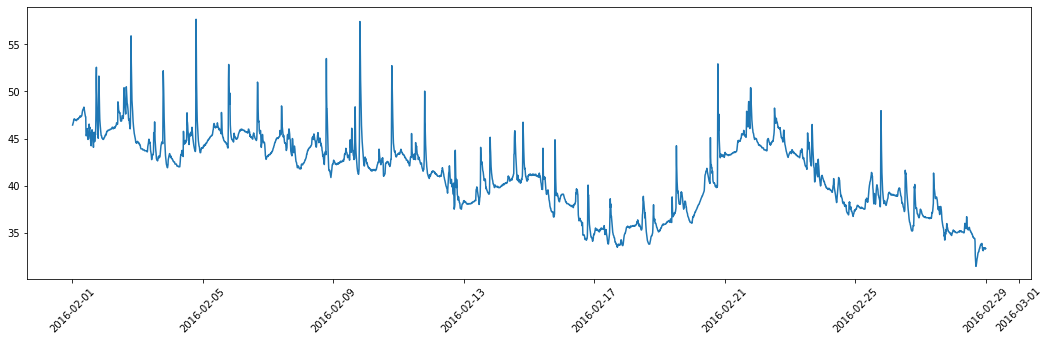

In [173]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(data['timestamp'], data['value'])
plt.xticks(rotation=45)
plt.show()

As we can see, there is too much fluctuation in the data. We will resample the data by taking mean values of all data points for every 1 hour. This should make the plot smoother. 

In [174]:
# To resample the data we need to make timestamp column as the index of the dataframe
data = data.set_index('timestamp')
data.head()

,value
timestamp,
2016-02-01 00:10:00,46.433333
2016-02-01 00:20:00,46.522500
2016-02-01 00:30:00,46.590000
2016-02-01 00:40:00,46.730000
2016-02-01 00:50:00,46.790000


In [175]:
# Resampling
data = data.resample("60T").mean()
print(f"Length after resampling: {len(data)}")
data.head()

Length after resampling: 672


,value
timestamp,
2016-02-01 00:00:00,46.613167
2016-02-01 01:00:00,47.050000
2016-02-01 02:00:00,46.966667
2016-02-01 03:00:00,47.011528
2016-02-01 04:00:00,47.122778


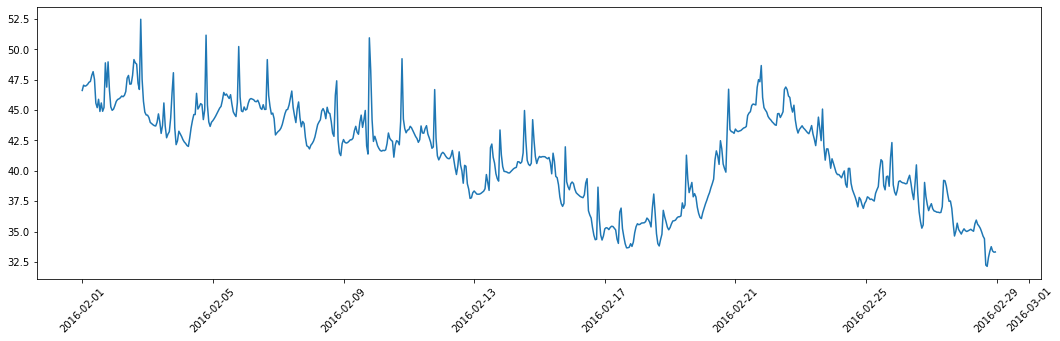

In [176]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(data['value'])
plt.xticks(rotation=45)
plt.show()

This will be our final dataset !!

Total length of the dataset is 672. We will use 648 values as training data. Once trained, our model will forecast 24 values into the future (24 hours of data).

In [177]:
train_data = data.head(n=648)
test_data = data.tail(n=24)

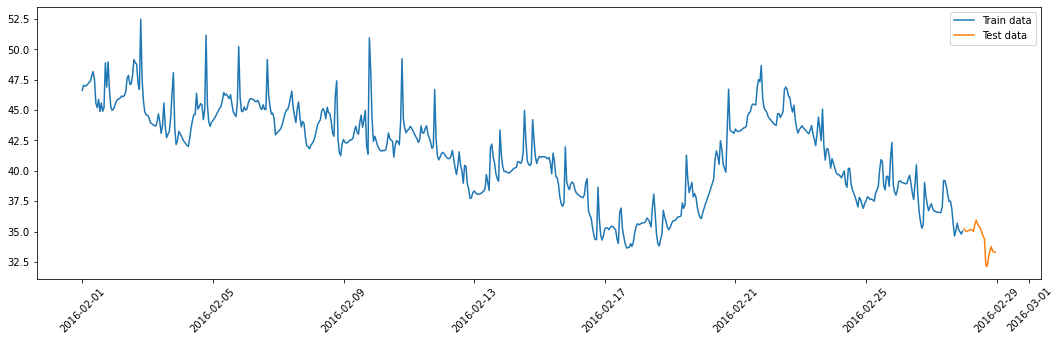

In [178]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['value'], label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.xticks(rotation=45)
plt.legend()
plt.show()

The orange plot at the end of graph is what we are trying to forecast

In [179]:
# Constant variables
forecast_horizon = 24
train_size = 648

# Baseline Model

Our baseline model will be a simple model which forecasts only mean value of train data. We will calculate Mean Squared Error (MSE) for this model and any model which has an MSE worse than this, is not to be considered. 

This may not look like a good baseline in cases where time series is not stationary. But when the time series is stationary, this is a really good baseline.

In [180]:
baseline_forecasts = forecast_horizon*[train_data['value'].mean()]
baseline_mse = mean_squared_error(test_data['value'].values, baseline_forecasts)

In [181]:
baseline_mse

50.71114830609276

## Stationary test

In [182]:
from statsmodels.tsa.stattools import adfuller

In [183]:
result = adfuller(train_data['value'].values)
print('ADF Statistic: %f' % result[0])

ADF Statistic: -1.913181


**The data is almost stationary. Higher negative values mean the data is more stationary. Very highly non stationary datasets have high positive ADF statistic. Since our dataset is almost stationary, we can use a small differencing value to make it more stationary.**

## Partial Auto Correlation Plot

Partial auto correlation plots give us the information about how much does the value of a datapoint depend on the values of it's previous datapoints. 

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


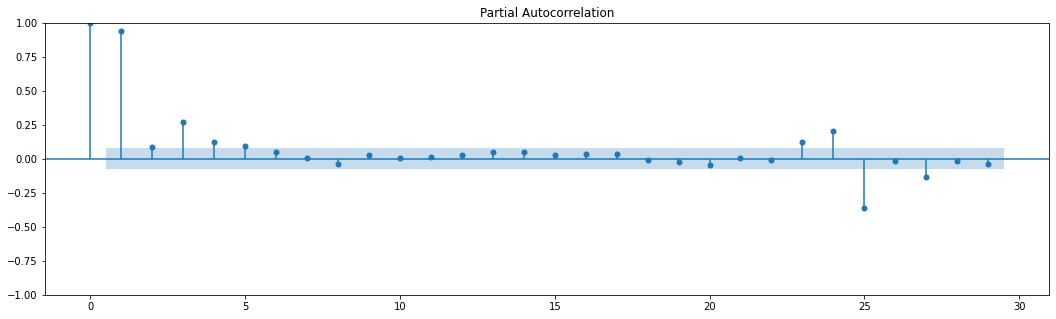

In [184]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['value'])
plt.show()

**Looking at above plots there's a strong correlation between only the first two values. For auto regressive models(ARIMA, SARIMA, Auto-ARIMA) AR paramater of 2 would be good. Since our data is almost stationary, small differcing of 1 would be right**

## Scaling data

In [185]:
# Scaling. We will use standard scaler
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data['value'].values.reshape(-1, 1))

# 1. ARIMA 

In [186]:
from statsmodels.tsa.arima.model import ARIMA

In [187]:
# Values for 'order' parameter are selected after hyper parameter tuning. These values give the lowest MSE of all the values 
# we tried.
model = ARIMA(scaled_train_data, order=(2,1,0))
model = model.fit()

In [188]:
# Forecast values for next 24 hours
forecasts = model.predict(start=scaled_train_data.size, end=scaled_train_data.size+forecast_horizon-1, dynamic=True)
forecasts = scaler.inverse_transform(forecasts.reshape(-1, 1))

### Plots 

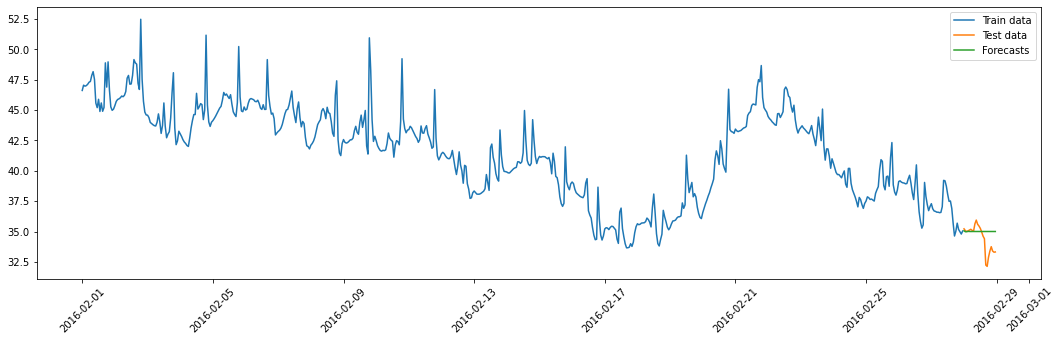

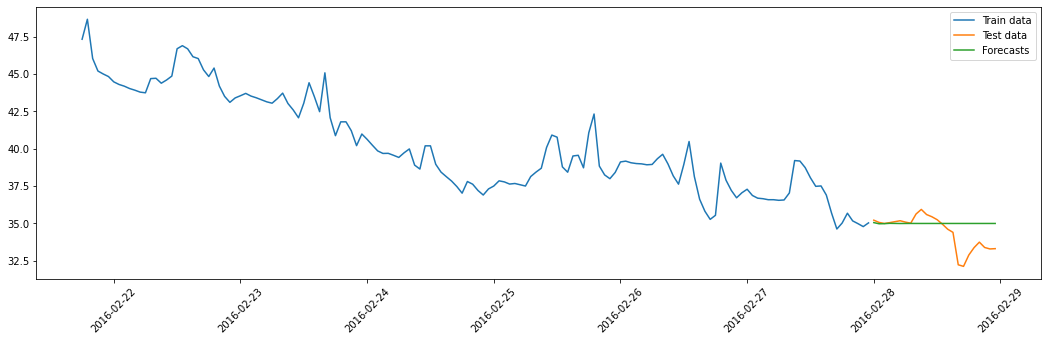

In [189]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['value'], label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['value'].tail(150), label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [190]:
mse = mean_squared_error(test_data['value'].values, forecasts)
mse

1.4738157571623158

**MSE is much better than the baseline model.  But the forecasts don't look good on plots.**

# 2. Prophet

In [191]:
from fbprophet import Prophet
import pandas as pd

In [192]:
import fbprophet
fbprophet.__version__

'0.7.1'

In [193]:
train_data.head() 

,value
timestamp,
2016-02-01 00:00:00,46.613167
2016-02-01 01:00:00,47.050000
2016-02-01 02:00:00,46.966667
2016-02-01 03:00:00,47.011528
2016-02-01 04:00:00,47.122778


Prophet requires input data to be a dataframe containing 2 columns. 'ds' column containing time values values in datetime format and 'y' column containing training data.

In [194]:
prophet_train_data = train_data.reset_index()
prophet_train_data.columns = ['ds', 'y']

In [195]:
prophet_train_data.head()

,ds,y
0,2016-02-01 00:00:00,46.613167
1,2016-02-01 01:00:00,47.050000
2,2016-02-01 02:00:00,46.966667
3,2016-02-01 03:00:00,47.011528
4,2016-02-01 04:00:00,47.122778


#### Define the model

In [196]:
model = Prophet()

#### Fit the model

In [197]:
model.fit(prophet_train_data)

Initial log joint probability = -3.22801


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1929.35     0.0039701       805.214      0.4501      0.8805      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1948.31    0.00229682       164.622      0.6091      0.6091      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1953.67   0.000127867       157.228     3.6e-07       0.001      387  LS failed, Hessian reset 
     299       1953.93   0.000277211       88.0936      0.9242      0.9242      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1956.56     0.0092999       161.491      0.4865      0.4865      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1957.5   0.000482311       101.545           1           1      6

In [198]:
# Create a forecast dataframe containing only dates
forecast_df = test_data.reset_index()
forecast_df = forecast_df[['timestamp']]
forecast_df.columns = ['ds']
forecast_df.head()

,ds
0,2016-02-28 00:00:00
1,2016-02-28 01:00:00
2,2016-02-28 02:00:00
3,2016-02-28 03:00:00
4,2016-02-28 04:00:00


#### Forecast values 

In [199]:
forecast_values = model.predict(forecast_df)
forecast_values = forecast_values[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

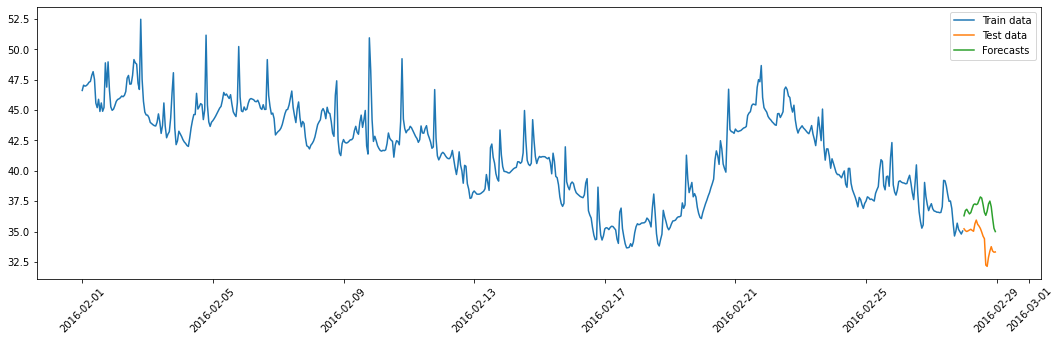

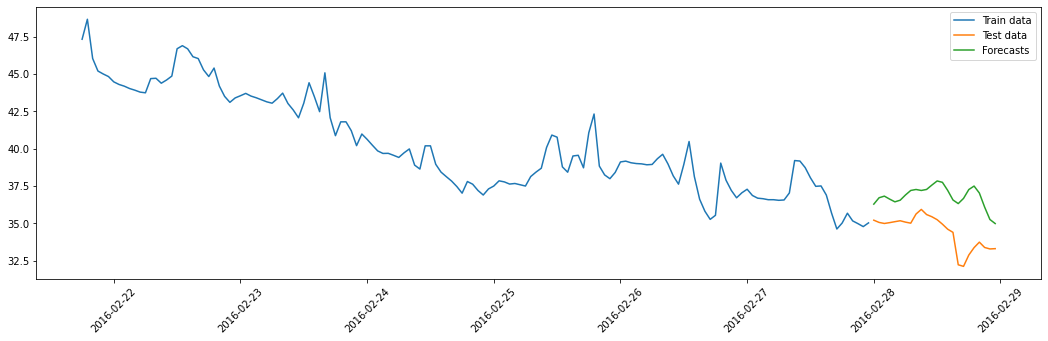

In [200]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['value'], label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(test_data.index, forecast_values['yhat'], label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['value'].tail(150), label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(forecast_values['ds'], forecast_values['yhat'], label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [201]:
mse = mean_squared_error(test_data['value'].values, forecast_values['yhat'].values)
mse

6.562898396673769

**Atleast there is some variation in the forecasts now, instead of a straight line like ARIMA results. But MSE is comparatively high.**

# 3. SARIMA

In [202]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [203]:
my_order = (2, 1, 0)
my_seasonal_order = (2, 1, 0, 5)

# define model
model = SARIMAX(scaled_train_data, order=my_order, seasonal_order=my_seasonal_order)

In [204]:
model_fit = model.fit(disp=0)

In [205]:
# Forecast total vaccinations for next 90 days
forecasts = model_fit.predict(start=scaled_train_data.size, end=scaled_train_data.size+forecast_horizon-1)
forecasts = scaler.inverse_transform(forecasts.reshape(-1, 1))

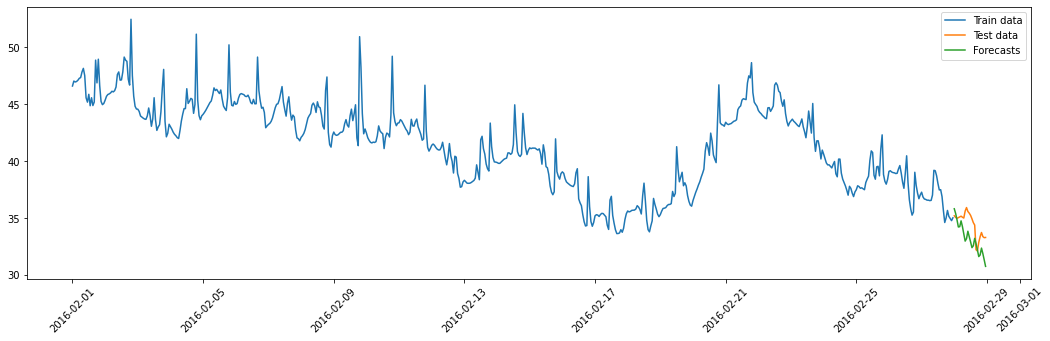

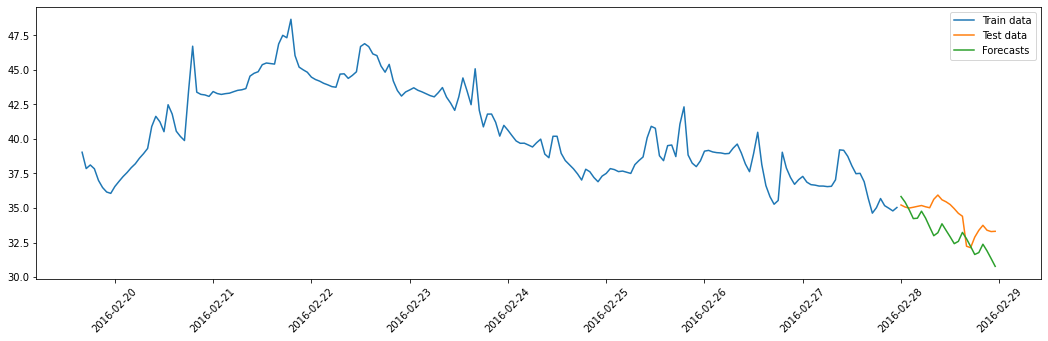

In [206]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['value'], label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['value'].tail(200), label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [207]:
mse = mean_squared_error(test_data['value'].values, forecasts)
mse

2.6075172418223884

**The forecasts are really good. The model is able to forecast the downward trend !.The model also has a really good MSE**

# 4. Auto ARIMA

In [208]:
# ! pip install pmdarima

In [209]:
from pmdarima.arima import auto_arima

In [210]:
arima_model = auto_arima(train_data['value'].values, start_p=0, d=1, start_q=0, max_p=5, max_d=0, max_q=5,
                         start_P=0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal=False, error_action='warn', 
                         suppress_warnings=True, trace=True, stepwise=True, random_state=20, n_fits=50)

/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2111.045, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2102.567, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2083.813, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2109.181, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2035.515, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2017.337, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2041.621, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2018.824, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2018.790, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2017.712, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2029.552, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2020.787, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2016.121, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2034.595, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]          

In [211]:
forecasts = arima_model.predict(n_periods=forecast_horizon)
forecast_df = pd.DataFrame(forecasts, index=test_data.index)
forecast_df.columns = ['forecasts']
forecast_df.head()

,forecasts
timestamp,
2016-02-28 00:00:00,35.151845
2016-02-28 01:00:00,35.134836
2016-02-28 02:00:00,35.102798
2016-02-28 03:00:00,35.095267
2016-02-28 04:00:00,35.099957


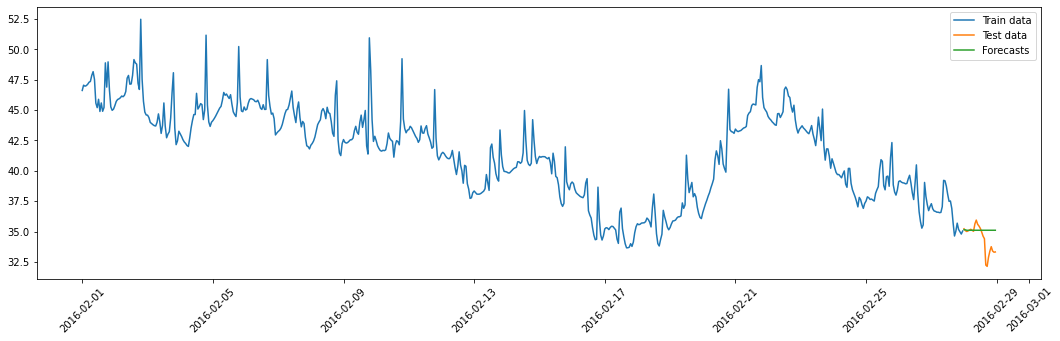

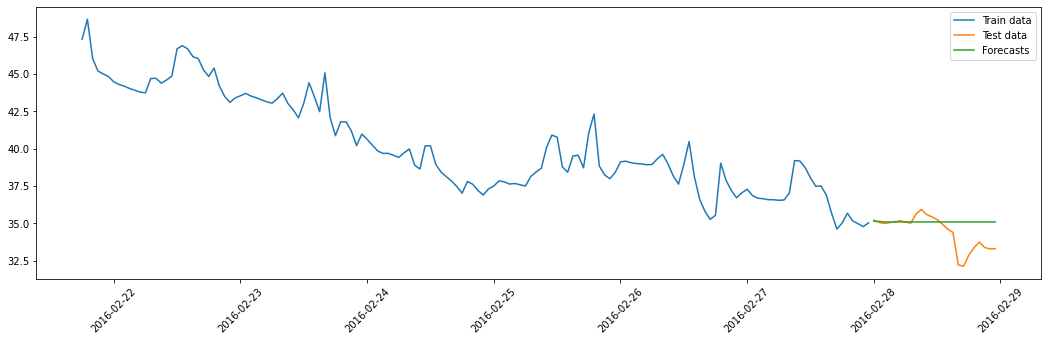

In [212]:
plt.rcParams["figure.figsize"] = (18,5)
plt.plot(train_data['value'], label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(test_data.index, forecasts, label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting only a part of training data
plt.plot(train_data['value'].tail(150), label='Train data')
plt.plot(test_data['value'], label='Test data')
plt.plot(forecast_df['forecasts'], label='Forecasts')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [213]:
mse = mean_squared_error(test_data['value'].values, forecasts)
mse

1.5952656509178522

## Conclusion

1. MSE is not a good measure of model performance when it comes to time series forecasting. 
2. Based on the above experiments and their results, SARIMA algorithm is much better than other algorithms when it comes to random time series forecasting.
3. When there is a clear trend or seasonality in the data, other algorithms, especially prophet, also gives some really good results. But that's not always true and when it comes to examples like the ones we showed above, SARIMA gives the best results.

